#Project 1

## Dataset

In [1]:
import os
import shutil
from random import random, seed
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.applications import vgg19, efficientnet
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.optimizers import schedules
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jehanbhathena/tire-texture-image-recognition")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/tire-texture-image-recognition/versions/1


In [3]:
root_path = path + "/Tire Textures"
train = root_path + "/training_data"
test = root_path + "/testing_data"

In [4]:
train_normal = train + "/normal"
train_cracked = train + "/cracked"

test_normal = test + "/normal"
test_cracked = test + "/cracked"

In [5]:
fold = ["/normal", "/cracked"]

In [6]:
filenames = os.listdir(train + '/normal')
image = imread(train_normal + '/' + filenames[0])
image.shape

(2464, 2464, 3)

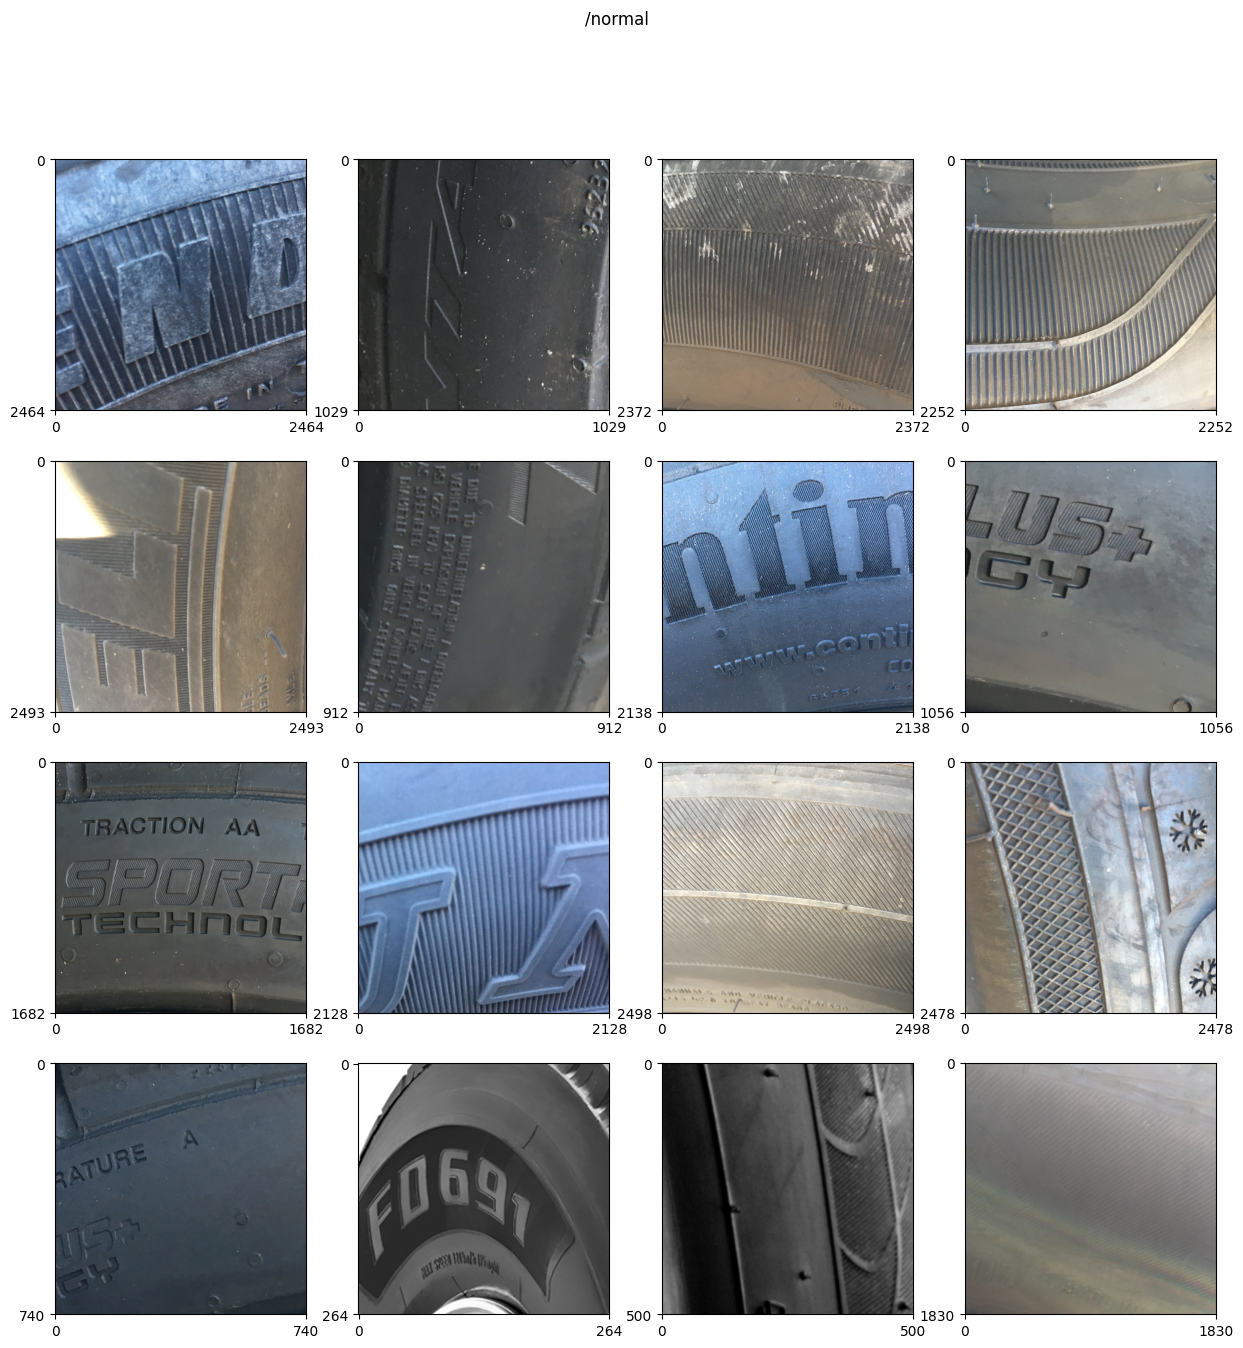

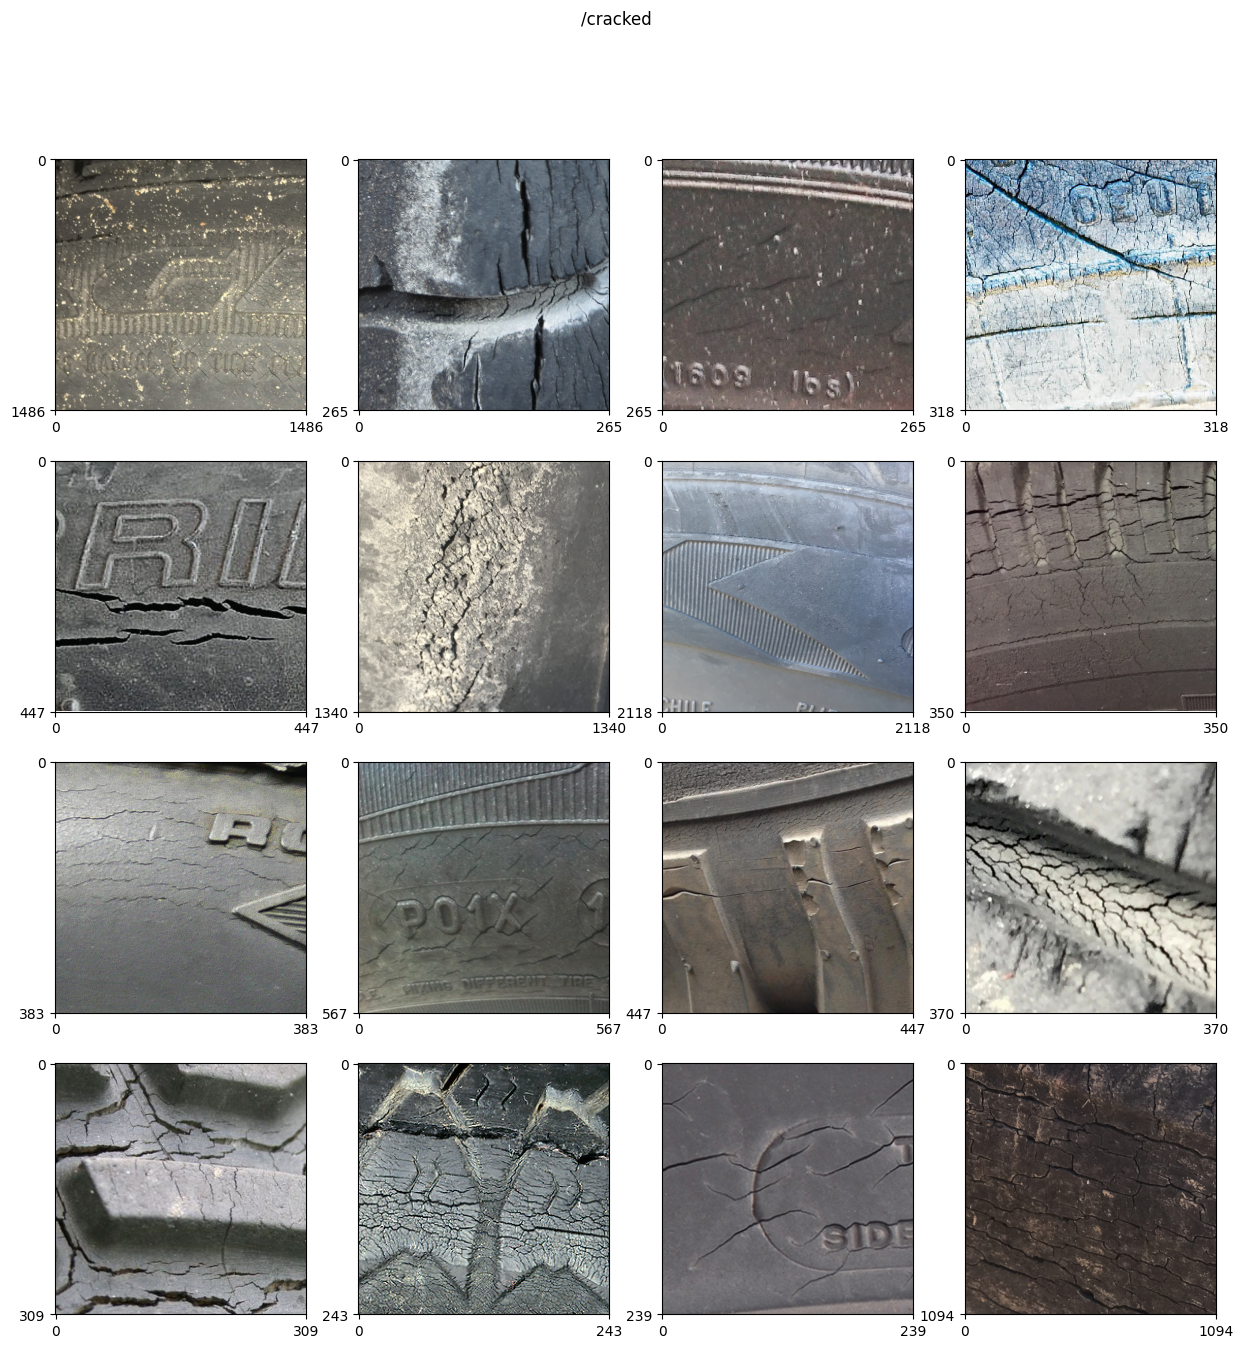

In [7]:
for folder in fold:
    filenames = os.listdir(train + folder)
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        filepath = train + folder + '/' + filenames[i]
        image = imread(filepath)
        plt.imshow(image)
        plt.xticks([0, image.shape[0]])
        plt.yticks([0, image.shape[1]])
    plt.suptitle(folder.capitalize())
    plt.show()
    print('\n')

## Data Processing

In [8]:
def load_images_from_folder(folder, label, target_size=(256, 256)):
    data_x = []
    data_y = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        try:
            image = Image.open(filepath)
            image = image.resize(target_size)
            image = image.convert('RGB')  # RGB 형식으로 변환
            data_x.append(np.array(image))
            data_y.append(label)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return data_x, data_y

In [9]:
train_x, train_y = [], []
test_x, test_y = [], []

train_normal_x, train_normal_y = load_images_from_folder(train_normal, 0)
train_cracked_x, train_cracked_y = load_images_from_folder(train_cracked, 1)
test_normal_x, test_normal_y = load_images_from_folder(test_normal, 0)
test_cracked_x, test_cracked_y = load_images_from_folder(test_cracked, 1)

# 데이터 병합
train_x.extend(train_normal_x + train_cracked_x)
train_y.extend(train_normal_y + train_cracked_y)
test_x.extend(test_normal_x + test_cracked_x)
test_y.extend(test_normal_y + test_cracked_y)

# NumPy 배열로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

## VGG-19 model

In [10]:
def build_vgg19(input_shape = (256, 256, 3), num_classes = 2):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model



In [11]:
model = build_vgg19()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.5271 - loss: 357.6490 - val_accuracy: 0.5816 - val_loss: 0.6906
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - accuracy: 0.5482 - loss: 0.6971 - val_accuracy: 0.5816 - val_loss: 0.6870
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 634ms/step - accuracy: 0.4987 - loss: 0.6942 - val_accuracy: 0.5816 - val_loss: 0.6844
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 603ms/step - accuracy: 0.5454 - loss: 0.7184 - val_accuracy: 0.5816 - val_loss: 0.6854
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 599ms/step - accuracy: 0.5166 - loss: 0.7807 - val_accuracy: 0.5816 - val_loss: 0.6821
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.5352 - loss: 0.7337 - val_accuracy: 0.5816 - val_loss: 0.6844
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - accuracy: 0.4811 - loss: 0.7281 - val_accuracy: 0.4184 - val_loss: 0.6967
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 601ms/step - accuracy: 0.5097 - loss: 0.6953 - val_accu

## VGG-19 Evaluate

In [16]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy:', test_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.6371 - loss: 0.6761
Test accuracy: 0.35384616255760193


In [14]:
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
f1 = f1_score(test_y, y_pred_classes)
print('F1 Score:', f1)

cm = confusion_matrix(test_y, y_pred_classes)
print('Confusion Matrix:')
print(cm)

recall = recall_score(test_y, y_pred_classes)
print('Recall:', recall)

precision = precision_score(test_y, y_pred_classes)
print('Precision:', precision)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 651ms/step
F1 Score: 0.0
Confusion Matrix:
[[115   0]
 [210   0]]
Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


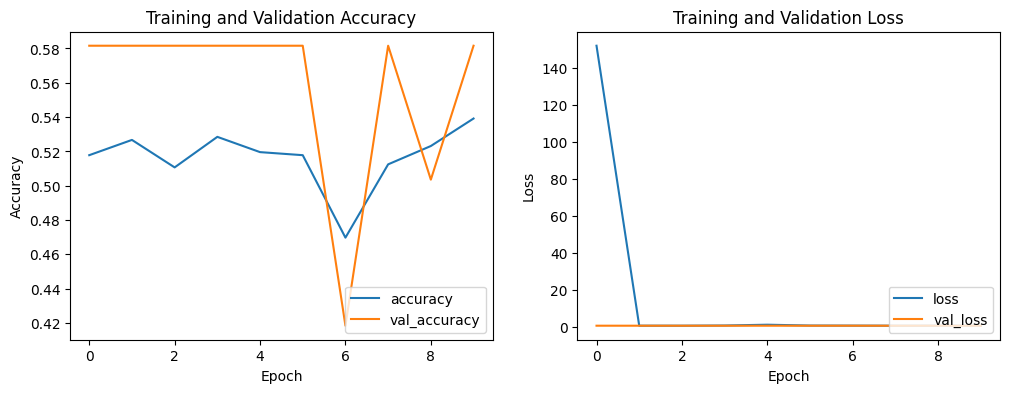

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()



## CNN

In [10]:
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

In [11]:
import keras
model = keras.models.Sequential([
    keras.Input(shape=(256, 256, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 123, 123, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 57, 57, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 55, 55, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 53, 53, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 22, 22, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,292,930 (20.19 MB)

 Trainable params: 5,292,930 (20.19 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
batch_size = 128
epochs = 10

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 128s 17s/step - accuracy: 0.5385 - loss: 0.6959 - val_accuracy: 0.0000e+00 - val_loss: 1.0639
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 592ms/step - accuracy: 0.6796 - loss: 0.7481 - val_accuracy: 0.0000e+00 - val_loss: 0.7555
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - accuracy: 0.6680 - loss: 0.6755 - val_accuracy: 0.0000e+00 - val_loss: 0.7945
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 594ms/step - accuracy: 0.6687 - loss: 0.6561 - val_accuracy: 0.0000e+00 - val_loss: 1.1031
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.6751 - loss: 0.6335 - val_accuracy: 0.0000e+00 - val_loss: 0.9950
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 602ms/step - accuracy: 0.6887 - loss: 0.6276 - val_accuracy: 0.0000e+00 - val_loss: 1.0755
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 599ms/step - accuracy: 0.6807 - loss: 0.6254 - val_accuracy: 0.0000e+00 - val_loss: 1.0064
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 600ms/step - accuracy: 0.6680 - loss: 0.6368 - val

## CNN evaluate

In [14]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9306265115737915
Test accuracy: 0.35384616255760193


In [15]:
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
f1 = f1_score(test_y, y_pred_classes)
print('F1 Score:', f1)

cm = confusion_matrix(test_y, y_pred_classes)
print('Confusion Matrix:')
print(cm)

recall = recall_score(test_y, y_pred_classes)
print('Recall:', recall)

precision = precision_score(test_y, y_pred_classes)
print('Precision:', precision)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
F1 Score: 0.0
Confusion Matrix:
[[115   0]
 [210   0]]
Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


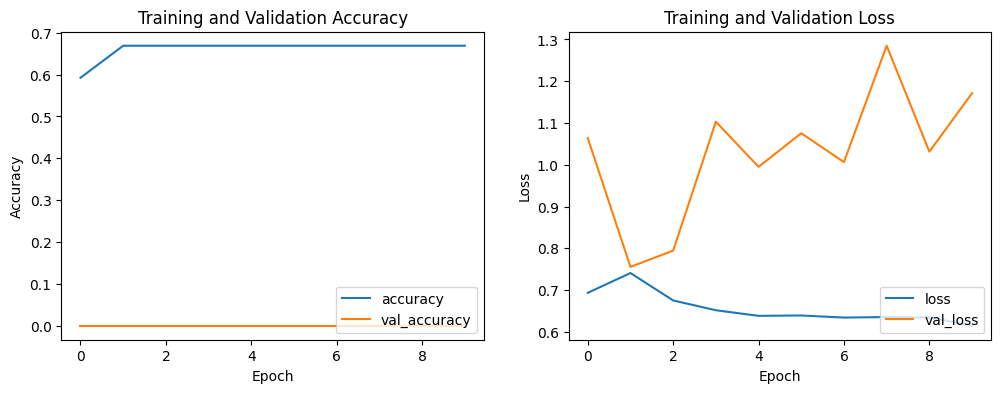

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

## InceptionNet

In [11]:
import keras
input_Layer = keras.layers.Input(shape=(256, 256, 3))

In [12]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_Layer)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

In [13]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_x, train_y, batch_size=128, epochs=10, validation_split=0.2)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 7s/step - accuracy: 0.6190 - loss: 38.7646 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 394ms/step - accuracy: 0.4857 - loss: 37.1039 - val_accuracy: 0.0000e+00 - val_loss: 87.2428
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.6816 - loss: 23.1037 - val_accuracy: 0.9149 - val_loss: 1.2988
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.5096 - loss: 9.6532 - val_accuracy: 0.2624 - val_loss: 16.5130
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.7277 - loss: 7.1986 - val_accuracy: 0.3475 - val_loss: 13.2064
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.7123 - loss: 3.1588 - val_accuracy: 0.8794 - val_loss: 1.1118
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.7085 - loss: 3.2020 - val_accuracy: 0.2128 - val_loss: 15.5819
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - a

## InceptionNet evaluate

In [14]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.0579593181610107
Test accuracy: 0.6646153926849365


In [15]:
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
f1 = f1_score(test_y, y_pred_classes)
print('F1 Score:', f1)

cm = confusion_matrix(test_y, y_pred_classes)
print('Confusion Matrix:')
print(cm)

recall = recall_score(test_y, y_pred_classes)
print('Recall:', recall)

precision = precision_score(test_y, y_pred_classes)
print('Precision:', precision)

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 776ms/step
F1 Score: 0.7093333333333334
Confusion Matrix:
[[ 83  32]
 [ 77 133]]
Recall: 0.6333333333333333
Precision: 0.806060606060606


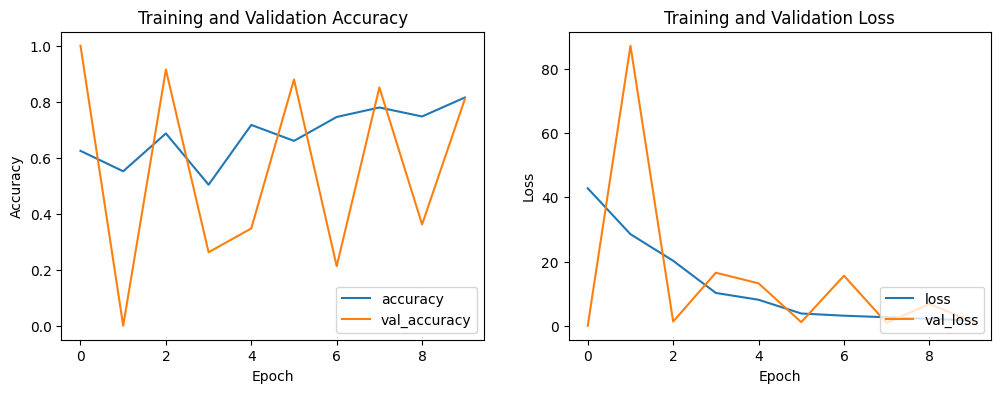

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

## ResNet

In [11]:
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model # Import the Model class
from keras.layers import Flatten, Dense
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 157,808,514 (601.99 MB)

 Trainable params: 134,220,802 (512.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
hist = model.fit(train_x, train_y, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6162 - loss: 56.4944 - val_accuracy: 0.4681 - val_loss: 51.1058
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - accuracy: 0.9280 - loss: 5.0194 - val_accuracy: 0.9645 - val_loss: 3.5433
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.9501 - loss: 1.6585 - val_accuracy: 0.7589 - val_loss: 25.3530
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.9634 - loss: 1.5569 - val_accuracy: 0.8085 - val_loss: 15.8971
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 436ms/step - accuracy: 0.9925 - loss: 0.1049 - val_accuracy: 0.8936 - val_loss: 8.0101
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.9905 - loss: 0.1046 - val_accuracy: 0.9149 - val_loss: 7.2161
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 1.0000 - loss: 1.5751e-04 - val_accuracy: 0.9078 - val_loss: 8.2790
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 1.0000 - loss: 3.0266e-10 - val_accuracy: 0.8794 

## ResNet evaluate

In [13]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 19.73345947265625
Test accuracy: 0.7353846430778503


In [14]:
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
f1 = f1_score(test_y, y_pred_classes)
print('F1 Score:', f1)

cm = confusion_matrix(test_y, y_pred_classes)
print('Confusion Matrix:')
print(cm)

recall = recall_score(test_y, y_pred_classes)
print('Recall:', recall)

precision = precision_score(test_y, y_pred_classes)
print('Precision:', precision)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step
F1 Score: 0.7542857142857143
Confusion Matrix:
[[107   8]
 [ 78 132]]
Recall: 0.6285714285714286
Precision: 0.9428571428571428


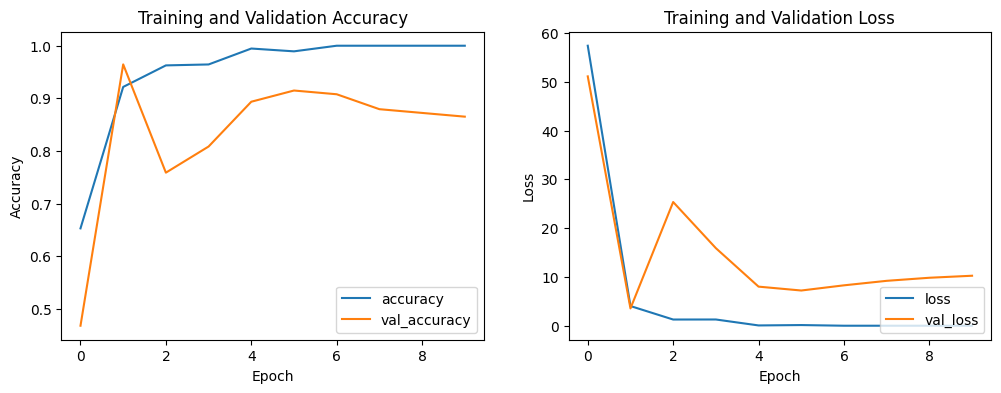

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

## Mobile Net

In [16]:
from keras.applications.mobilenet_v2 import MobileNetV2
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in mobilenet.layers:
    layer.trainable = False

x = mobilenet.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobilenet.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

<ipython-input-16-6f449308b632>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 86,147,138 (328.63 MB)

 Trainable params: 83,889,154 (320.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
hist = model.fit(train_x, train_y, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.5494 - loss: 30.6811 - val_accuracy: 0.0355 - val_loss: 140.4922
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.7101 - loss: 32.1991 - val_accuracy: 0.9362 - val_loss: 1.6441
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7364 - loss: 12.7047 - val_accuracy: 0.4397 - val_loss: 27.7981
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8569 - loss: 4.0818 - val_accuracy: 0.8794 - val_loss: 2.6199
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8575 - loss: 2.4790 - val_accuracy: 0.5674 - val_loss: 12.8892
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.9117 - loss: 1.1698 - val_accuracy: 0.7589 - val_loss: 5.5523
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9549 - loss: 0.3732 - val_accuracy: 0.7943 - val_loss: 4.3397
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9842 - loss: 0.1273 - val_accuracy: 0.6028 - val

## MobileNet evaluate

In [18]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7.4575300216674805
Test accuracy: 0.6399999856948853


In [19]:
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
f1 = f1_score(test_y, y_pred_classes)
print('F1 Score:', f1)

cm = confusion_matrix(test_y, y_pred_classes)
print('Confusion Matrix:')
print(cm)

recall = recall_score(test_y, y_pred_classes)
print('Recall:', recall)

precision = precision_score(test_y, y_pred_classes)
print('Precision:', precision)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step
F1 Score: 0.6507462686567164
Confusion Matrix:
[[ 99  16]
 [101 109]]
Recall: 0.5190476190476191
Precision: 0.872


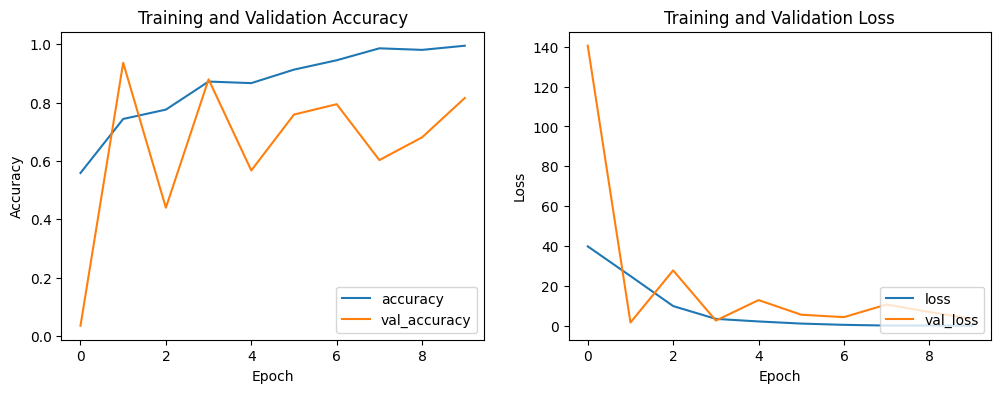

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()